In [1]:
import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt
from qutip import *
from tqdm import tqdm
from numpy import sin, cos, sqrt, array, linspace, pi

\begin{equation} \label{eq:Heff_c} 
     \hat{H}^{eff}_{OptoMech}=-(\Delta +\frac{g^2_{ac}}{\Delta_{al}} ) \hat{a}^{\dagger} \hat{a} + \omega_m \hat{b}^{\dagger} \hat{b} + \alpha (\hat{b}+\hat{b}^{\dagger}) - g_{eff} \hat{a}^{\dagger}\hat{a}(\hat{b}+\hat{b}^{\dagger}) - iF_L (\hat{a}^\dagger-\hat{a} )
\end{equation}

$$
\alpha = g_{am} (1-\frac{g_{ac}^2}{\Delta_{aL}^2}) , ~~~~~ g_{eff} = g_{cm} + 2 \frac{g_{am}g_{ac}^2}{\Delta_{aL}^2}
$$

$$
\Delta = \omega_L - \omega_c     , ~~~~~ \Delta_{aL}= \omega_a - \omega_L
$$

#### Displaced $H_{D}^{eff}$ 
$
\hat{b}_n = \hat{b} + \alpha/\omega_m
$

$
\hat{b}^{\dagger}_n = \hat{b}^{\dagger} + \alpha/\omega_m
$

\begin{equation} \label{eq:Heff_c2} 
     \hat{H}^{eff}_{D}=-(\Delta +\frac{g^2_{ac}}{\Delta_{aL}} - \frac{2 \alpha g_{eff}}{\omega_m} ) \hat{a}^{\dagger} \hat{a} + 
     \omega_m \hat{b}_n^{\dagger} \hat{b}_n  - g_{eff} \hat{a}^{\dagger}\hat{a}(\hat{b}_n+\hat{b}^{\dagger}_n) - iF_L (\hat{a}^\dagger-\hat{a} )
\end{equation}

In [6]:
def mean_steady2a(w_m, w_L, w_a, Delta_aL, w_cLlist, g_ac, g_cm, g_am,g_eff, n_th, kappa, gamma, F_L):
    
    N = 5 #5                  # number of cavity fock states
    M = 9 #9                  # number of phonon fock states  
    
    #alpha = g_am * (1-(g_ac/Delta_aL)**2)
    alpha = - (g_eff-g_cm)/2.
    
    a = tensor(destroy(N), qeye(M))  # , qeye(2)
    b = tensor(qeye(N), destroy(M))
    #sigma_z = tensor(qeye(N), qeye(M)) # , sigmaz() , , sigmap() , sigmam()
    #sigma_p = tensor(qeye(N), qeye(M))  # raising and lowering ops for atom
    #sigma_m = tensor(qeye(N), qeye(M))
    
    num_a = a.dag() * a 
    num_b = b.dag() * b  

    c_ops = []
    gamma_a = gamma
    rate = kappa                              # kappa is cavity decay rate
    if rate > 0.0 : 
        c_ops.append(a * sqrt(rate))
    rate = n_th * gamma                       # gamma is decay for mechanical resonator 
    if rate > 0.0: 
        c_ops.append(b.dag() * sqrt(rate))
    rate = (n_th+1) * gamma
    if rate > 0.0 : 
        c_ops.append(b * sqrt(rate))
    rate = gamma_a
    if rate > 0.0 : 
        c_ops.append(sigma_m * sqrt(rate))
    idx = 0 
    n   = np.zeros(shape(w_cLlist))
    #####
    for w_c in w_cLlist:    
        
        Heff_Cav  = -(w_L -w_c + (g_ac**2)/Delta_aL) * num_a # + (2* alpha * g_cm/w_m) * num_a
        Heff_Mech =  w_m * num_b + alpha * (b.dag() + b) # 
        #### Interaction  Hamiltonian
        Heff_Int  =  - g_eff * num_a *(b + b.dag())
        # Laser drive 
        H_drive   = - 1j* F_L *(a.dag()-a)   
        ### constant value 
        #H_0 = - 0.5 * Delta_aL - (g_ac**2)/(2*Delta_aL)               ## 
        ##### Total H: 
        H =   Heff_Cav + Heff_Mech + Heff_Int + H_drive   #+ H_0
        #########################
        ########################
        # <n>
        solvers = ['direct','power','eigen','iterative-gmres','iterative-bicgstab']  # methods 
        ## only for ['iterative-gmres','iterative-bicgstab']---  use_rcm = True
        use_rcm = False
        rho = steadystate(H, c_ops, method=solvers[2], tol=1e-14) # ,use_rcm=use_rcm ,use_precond=True,
        n[idx] = expect(a.dag()*a,rho)
      
        idx +=1

    H0 =  w_m * num_b + H_drive   # H0 at resonance and g=0
    return  n, c_ops, a, H0

### Parameters 

In [7]:
Set = 2               ##### set of Parametrs    

if (Set==1):
    w_a  = 105      #[ 1500 ]   [1052  ]
    w_L  =  100 
    g_am = 0.5         #[  50   ]  [.54    ] 
    g_ac =  5   
elif Set==2:
    w_a  = 1500      #[ 15000 ]  [10520  ]
    w_L =  1000 
    g_am = 50      #[  50   ]   [.54     ]
    g_ac =  50
elif Set==3: 
    w_a  = 15000      #[ 15000 ]  [10520  ]
    w_L =  10000 
    g_am = 50      #[  50   ]   [.54     ]
    g_ac =  500   

w_m  = 1                       # mechanical frequency
n_th_i   = [0, 0, 1, 0 ]
gamma    = w_m/20.                                ## gamma is decay for mechanical resonator 
kappa_i  = [w_m/2., 2. * w_m, w_m/2., w_m/2.]     # kappa is cavity decay rate
g_cm = 0.001 * w_m               # cavity-resonator couplng  10 ^-5


In [8]:
Delta_aL = w_a - w_L
w_c  = w_L +(g_ac**2)/Delta_aL

alpha = g_am * (1-(g_ac/Delta_aL)**2) 
shift = g_ac**2/Delta_aL
g_eff = g_cm + 2 * g_am * (g_ac/Delta_aL)**2
g_eff
#alpha
shift


5.0

## Display Figures 

100%|██████████| 4/4 [00:53<00:00, 13.49s/it]


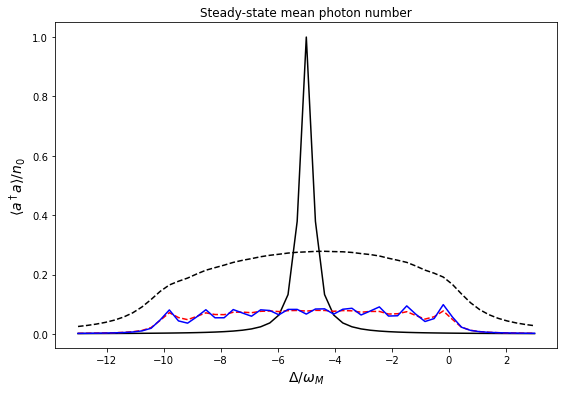

In [9]:
tlist = np.linspace(0, 100.0, 800)        # Time evolution
fig, ax= plt.subplots(1,1,figsize=(9,6))
linestyle =['-','--','--','-']
color=['black', 'black', 'r', 'b']


Delta_aL = w_a - w_L
minn_c = w_L + shift + 8  #    w_L + 490
maxx_c = w_L + shift - 8   #    w_L + 470

w_cLlist = np.linspace((minn_c )* w_m, (maxx_c ) * w_m, 51)  # so \Delta change between [-465, -495]   
g_ef = g_cm + 2 * g_am * (g_ac/Delta_aL)**2

#### to save data
xplot = []                                 #######=====###########====####
pllot2a  = np.zeros((len(w_cLlist),4))       ############tlist
#pllot4aa  = np.zeros((len(w_cLlist),4))       ############wlist

for i in tqdm([0, 1, 2, 3 ]): #[0, 1, 2, 3]:
    g_eff_i = [0, g_ef,g_ef,g_ef]
    g_eff= g_eff_i[i]
    shift = g_ac**2/Delta_aL
    kappa = kappa_i[i]
    n_th  = n_th_i[i]
    F_L   = sqrt(kappa) * 0.01        #   Laser amplitude        
    n, c_ops, a, H0 = mean_steady2a(w_m, w_L, w_a, Delta_aL, w_cLlist, g_ac, g_cm, g_am,g_eff, n_th, kappa, gamma, F_L)    

    solvers = ['direct','power','eigen','iterative-gmres','iterative-bicgstab']  # methods 
    # only for ['iterative-gmres','iterative-bicgstab']---  use_rcm = True
    use_rcm = False        
    #  <n_0>
    #rho0 = steadystate(H0, c_ops, method=solvers[2], tol=1e-14)  ### to
    #n_0 = expect(a.dag()*a,rho0) 
    n_0 = 4 * (F_L/kappa)**2        # alternative way for n_0
    
    ax.plot((w_L - w_cLlist )/w_m, n/n_0, linestyle =linestyle[i], color=color[i])
    
    xplot = w_L - w_cLlist/w_m 
    pllot2a[: , i] = n/n_0
        
ax.set_xlabel(r'$\Delta/ \omega_M $', fontsize=14)
ax.set_ylabel(r'$\langle a^ \dagger a  \rangle /n_0 $', fontsize=14)    # (r'$ e $',fontsize=16,color='red')
ax.set_title('Steady-state mean photon number')
#######        
plt.savefig("SteaSt_Mean_Hyb_Modi_1500.pdf") # , dpi=50
plt.show()

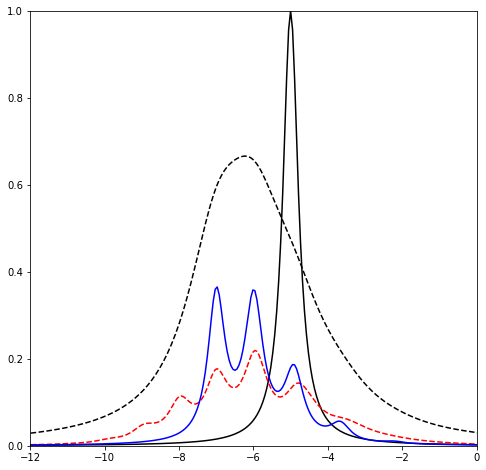

In [9]:

data2a = np.column_stack([xplot, pllot2a[: , 0],pllot2a[: , 1] ,pllot2a[: , 2], pllot2a[: , 3]])
np.savetxt("Fig2a1500Modf_SS.txt" , data2a, fmt=['%s','%s','%s','%s','%s'])

linestyle =['-.','-','--','--','-']
color=['t','black', 'black', 'r', 'b']
fig, ax= plt.subplots(1,1,figsize=(8,8))
for i in [1,2,3,4]:
    plt.plot(xplot, data2a[:,i], linestyle = linestyle[i], color = color[i])
    
ax.set_xlim([-12,0])
ax.set_ylim([0,1])
plt.savefig("SteaSt_MeanPhoton_Modi_2a_1500.pdf", dpi=150)
plt.show()


In [5]:
def mean_steady2_a(w_m, w_L, w_a, Delta_aL, w_cLlist, g_ac, g_cm, g_am,g_eff, n_th, kappa, gamma, F_L):
    N = 5 #5                  # number of cavity fock states
    M = 10 #9                  # number of phonon fock states  
    
    alpha = g_am * (1-(g_ac/Delta_aL)**2)
    
    a = tensor(destroy(N), qeye(M))  # , qeye(2)
    b = tensor(qeye(N), destroy(M))
    #sigma_z = tensor(qeye(N), qeye(M)) # , sigmaz() , , sigmap() , sigmam()
    #sigma_p = tensor(qeye(N), qeye(M))  # raising and lowering ops for atom
    #sigma_m = tensor(qeye(N), qeye(M))
    
    num_a = a.dag() * a 
    num_b = b.dag() * b  

    c_ops = []
    gamma_a = gamma
    rate = kappa                              # kappa is cavity decay rate
    if rate > 0.0 : 
        c_ops.append(a * sqrt(rate))
    rate = n_th * gamma                       # gamma is decay for mechanical resonator 
    if rate > 0.0: 
        c_ops.append(b.dag() * sqrt(rate))
    rate = (n_th+1) * gamma
    if rate > 0.0 : 
        c_ops.append(b * sqrt(rate))
    #rate = gamma_a
    #if rate > 0.0 : 
    #    c_ops.append(sigma_m * sqrt(rate))
    idx = 0 
    n   = np.zeros(shape(w_cLlist))
    #####
    for w_c in w_cLlist:    
        
        Heff_Cav  = -(w_L -w_c - (g_ac**2)/Delta_aL) * num_a #+ (2* alpha * g_cm/w_m - w_c -delta_LR) * num_a
        #H_Atm  = -0.5 * (delta_LR + w_c-w_a) *sigma_z # #  ????? -(delta_LR)
        Heff_Mech =  w_m * num_b + alpha * (b.dag() + b) # 
        #### Interaction  Hamiltonian
        Heff_Int  =  - g_eff * num_a *(b + b.dag())
        #H_Int  = 1j * g_ac * (sigma_p * a - sigma_m * a.dag())- g_cm * num_a *(b.dag() + b)- g_am * sigma_z * (b.dag() + b) 
        # Laser drive 
        H_drive   = - 1j* F_L *(a.dag()-a)   
        ### constant value 
        H_0 = - 0.5 * Delta_aL - (g_ac**2)/(2*Delta_aL)               ## +
        ##### Total H: 
        H =  H_0 + Heff_Cav + Heff_Mech + Heff_Int + H_drive   #+ H_0
        # at resonance and for g_eff=0

        #########################
        ########################
        solvers = ['direct','power','eigen','iterative-gmres','iterative-bicgstab']  # methods 
        ## only for ['iterative-gmres','iterative-bicgstab']---  use_rcm = True
        use_rcm = False
        rho = steadystate(H, c_ops, method=solvers[2], tol=1e-14) # ,use_rcm=use_rcm ,use_precond=True,
        n[idx] = expect(a.dag()*a,rho)
      
        idx +=1

    H0 =  w_m * num_b + H_drive   # H at resonance
    return  n, c_ops, a, H0

In [6]:
w_m  = 1                       # mechanical frequency

Set = 10          ##### set of Parametrs set      1  ------> YES

if (Set==1):
    w_a_j  = [ 1052 ]
    w_L_j =  [1000  ]
    g_am_j = [  0.54   ]
    g_ac_j = [1.0 * 50]
else:
    w_a_j  = [ 10520 ]
    w_L_j =  [10000  ]
    g_am_j = [  0.54   ]
    g_ac_j = [1.0 * 500]

"""w_a_j  = [ 1500 ]
w_L_j =  [1000 ]
g_am_j = [  50 ]
g_ac_j = [ 1.0 * 50 ]
"""
Delta_aL = w_a_j[0] - w_L_j[0]
shift = g_ac_j[0]**2/Delta_aL
#minn_c = w_L_j[0] + 7 #- shift  #minn_c = w_L - 4
#maxx_c = w_L_j[0] - 13 #+ shift  #maxx_c = w_L + 11
######
#g_ef = g_cm + 2 * g_am_j[2] * (g_ac_j[2]/Delta_aL)**2
#shift = g_ac_j[2]**2/Delta_aL
n_th_i   = [0, 0, 1, 0 ]
gamma    = w_m/20.                                ## gamma is decay for mechanical resonator 
kappa_i  = [w_m/2., 2. * w_m, w_m/2., w_m/2.]     # kappa is cavity decay rate
g_cm = 0.001 * w_m               # cavity-resonator couplng  10 ^-5
#g_ef
shift

480.7692307692308

100%|██████████| 4/4 [04:04<00:00, 61.04s/it]


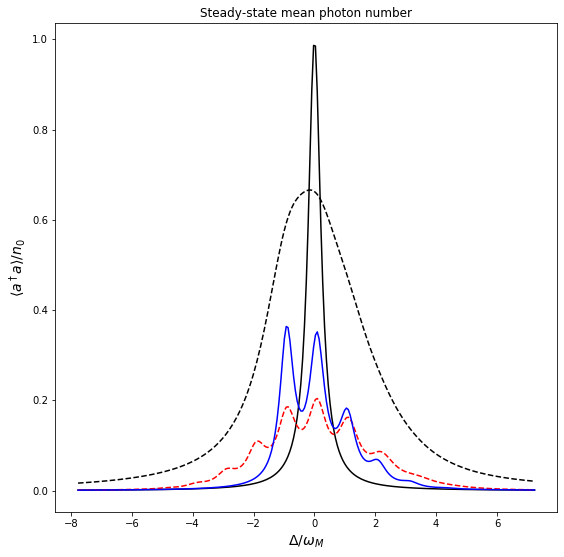

In [17]:
tlist = np.linspace(0, 200.0, 2000)
fig, ax= plt.subplots(1,1,figsize=(9,9))
linestyle =['-','--','--','-']
color=['black', 'black', 'r', 'b']
####### save data ######

for j in [0]:
    w_a  = w_a_j[j]  
    w_L  = w_L_j[j]
    Delta_aL = w_a - w_L
    
    g_am = g_am_j[j] 
    g_ac = g_ac_j[j]
    g_ef = g_cm + 2 * g_am * (g_ac/w_a)**2
    g_i = [0, g_ef, g_ef,g_ef]
    
    minn_c = w_L - 473 #w_L + 4 #- shift  #minn_c = w_L - 4
    maxx_c = w_L - 488 #w_L - 14 #+ shift  #maxx_c = w_L + 11
    w_cLlist = np.linspace((minn_c )* w_m, (maxx_c ) * w_m, 251)
    g_ef = g_cm + 2 * g_am * (g_ac/Delta_aL)**2
    
    #pllot  = np.zeros((len(w_cLlist),4))
    #xplot = []
    for i in tqdm([0, 1, 2, 3 ]): #[0, 1, 2, 3]:
        g_eff_i = [0, g_ef,g_ef,g_ef]
        g_eff= g_eff_i[i]
        kappa = kappa_i[i]
        n_th            = n_th_i[i]
        F_L   = sqrt(kappa) * 0.01        # 
        n, c_ops, a, H0 = mean_steady2_a(w_m, w_L, w_a, Delta_aL, w_cLlist, g_ac, g_cm, g_am,g_eff, n_th, kappa, gamma, F_L)    

        solvers = ['direct','power','eigen','iterative-gmres','iterative-bicgstab']  # methods 
        # only for ['iterative-gmres','iterative-bicgstab']---  use_rcm = True
        use_rcm = False
        rho0 = steadystate(H0, c_ops, method=solvers[2], tol=1e-14)
        n_0 = expect(a.dag()*a,rho0) 
        
        ax.plot(w_L - w_cLlist/w_m - shift, n/n_0, linestyle =linestyle[i], color=color[i])    # 
        ax.set_xlabel(r'$\Delta/ \omega_M $', fontsize=14)
        ax.set_ylabel(r'$\langle a^ \dagger a  \rangle /n_0 $', fontsize=14)    # (r'$ e $',fontsize=16,color='red')
        ax.set_title('Steady-state mean photon number')
        
        #xplot = w_L - w_cLlist/w_m + shift
        #pllot[: , i] = n/n_0
        
#######
"""ax[0].text(-5, .8, r'(a): $\omega_m$=1, ',color='red', fontsize=12)
ax[0].text(-5, .65, r'$\omega_L$=700,',color='red', fontsize=12)
ax[0].text(-5, .58, r'$\omega_a$=900,',color='red', fontsize=12)
ax[0].text(-5, .50, r'$g_{am}$=30,',color='red', fontsize=12)
ax[0].text(-5, .41, r'$g_{ac}$=0.86 $g_{am}$',color='red', fontsize=12)

ax[1].text(-5, .8, r'(b): $\omega_m$=1, ',color='red', fontsize=12) # , bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10}
ax[1].text(-5, .7, r'$\omega_L$=840,',color='red', fontsize=12)
ax[1].text(-5, .6, r'$\omega_a$=900,',color='red', fontsize=12)
ax[1].text(-5, .52, r'$g_{am}$=11,',color='red', fontsize=12)
ax[1].text(-5, .42, r'$g_{ac}$=1.16 $g_{am}$',color='red', fontsize=12)

ax[2].text(-5, .8, r'(c): $\omega_m$=1, ',color='red', fontsize=12) # , bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10}
ax[2].text(-5, .7, r'$\omega_L$=1000,',color='red', fontsize=12)
ax[2].text(-5, .6, r'$\omega_a$=1500,',color='red', fontsize=12)
ax[2].text(-5, .51, r'$g_{am}$=50,',color='red', fontsize=12)
ax[2].text(-5, .44, r'$g_{ac}$= $g_{am}$',color='red', fontsize=12)"""
#######        
plt.savefig("SteaSt_MeanPhoton_Fig2aa.pdf") # , dpi=50
plt.show()

### Fig. 2a

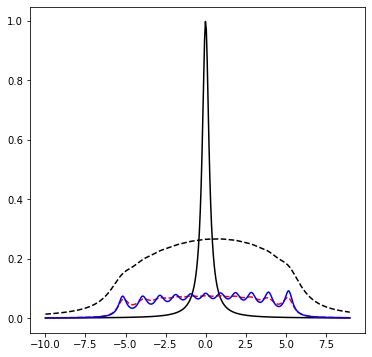

In [43]:

"""xarray = np.array([2, 4, 6, 8, 10, 12])
yarray = np.array([0, 1, 2, 3, 4, 5])
zarray = np.array([10, 8.5, 7.4, 6.7656, 0.004, -1.54])
data = np.column_stack([xarray, yarray , zarray])
np.savetxt("test.txt" , data, fmt=['%s','%s','%s'])
data = np.loadtxt('test.txt')
plt.plot(data[:,0], data[:,1], data[:,2])
plt.show()"""
xarray = xplot
black = pllot[: , 0]
bblack = pllot[: , 1]
red = pllot[: , 2]
blue = pllot[: , 3]
data2a = np.column_stack([xarray, black , bblack,red ,blue])
np.savetxt("Fig2a.txt" , data2a, fmt=['%s','%s','%s','%s','%s'])

linestyle =['-','--','--','-']
color=['black', 'black', 'r', 'b']
fig, ax= plt.subplots(1,1,figsize=(6,6))
for i in [1,2,3,4]:
    plt.plot(xarray-10, data2a[:,i], linestyle = linestyle[i-1], color = color[i-1])
plt.show()

In [52]:
def mean_steady1a(w_m, w_L, w_a, Delta_aL, w_cLlist, g_ac, g_cm, g_am,g_eff, n_th, kappa, gamma, F_L):
    N = 5 #5                  # number of cavity fock states
    M = 10 #9                  # number of phonon fock states  
    
    alpha = g_am * (1-(g_ac/Delta_aL)**2)
    
    a = tensor(destroy(N), qeye(M))  # , qeye(2)
    b = tensor(qeye(N), destroy(M))
    #sigma_z = tensor(qeye(N), qeye(M)) # , sigmaz() , , sigmap() , sigmam()
    #sigma_p = tensor(qeye(N), qeye(M))  # raising and lowering ops for atom
    #sigma_m = tensor(qeye(N), qeye(M))
    
    num_a = a.dag() * a 
    num_b = b.dag() * b  

    c_ops = []
    gamma_a = gamma
    rate = kappa                              # kappa is cavity decay rate
    if rate > 0.0 : 
        c_ops.append(a * sqrt(rate))
    rate = n_th * gamma                       # gamma is decay for mechanical resonator 
    if rate > 0.0: 
        c_ops.append(b.dag() * sqrt(rate))
    rate = (n_th+1) * gamma
    if rate > 0.0 : 
        c_ops.append(b * sqrt(rate))
    #rate = gamma_a
    #if rate > 0.0 : 
    #    c_ops.append(sigma_m * sqrt(rate))
    idx = 0 
    n   = np.zeros(shape(w_cLlist))
    #####
    for w_c in w_cLlist:    
        
        Heff_Cav  = -(w_L -w_c - (g_ac**2)/Delta_aL) * num_a #+ (2* alpha * g_cm/w_m - w_c -delta_LR) * num_a
        #H_Atm  = -0.5 * (delta_LR + w_c-w_a) *sigma_z # #  ????? -(delta_LR)
        Heff_Mech =  w_m * num_b + alpha * (b.dag() + b) # 
        #### Interaction  Hamiltonian
        Heff_Int  =  - g_eff * num_a *(b + b.dag())
        #H_Int  = 1j * g_ac * (sigma_p * a - sigma_m * a.dag())- g_cm * num_a *(b.dag() + b)- g_am * sigma_z * (b.dag() + b) 
        # Laser drive 
        H_drive   = - 1j* F_L *(a.dag()-a)   
        ### constant value 
        H_0 = - 0.5 * Delta_aL - (g_ac**2)/(2*Delta_aL)               ## +
        ##### Total H: 
        H =  H_0 + Heff_Cav + Heff_Mech + Heff_Int + H_drive   #+ H_0
        # at resonance and for g_eff=0

        #########################
        ########################
        solvers = ['direct','power','eigen','iterative-gmres','iterative-bicgstab']  # methods 
        ## only for ['iterative-gmres','iterative-bicgstab']---  use_rcm = True
        use_rcm = False
        rho = steadystate(H, c_ops, method=solvers[2], tol=1e-14) # ,use_rcm=use_rcm ,use_precond=True,
        n[idx] = expect(a.dag()*a,rho)
      
        idx +=1

    H0 =  w_m * num_b + H_drive   # H at resonance
    return  n, c_ops, a, H0

In [2]:
w_m  = 1                       # mechanical frequency
w_a_j  = [ 15000 ]
w_L_j =  [10000 ]
g_am_j = [ 50    ]
g_ac_j = [1.0 * 500 ]

n_th_i   = [0, 0, 1, 0 ]
gamma    = w_m/20.                                ## gamma is decay for mechanical resonator 
kappa_i  = [w_m/2., 2. * w_m, w_m/2., w_m/2.]     # kappa is cavity decay rate
g_cm = 0.001 * w_m               # cavity-resonator couplng  10 ^-5

Delta_aL = w_a_j[0] - w_L_j[0]
shift = g_ac_j[0]**2/Delta_aL
shift
#g_eff

50.0

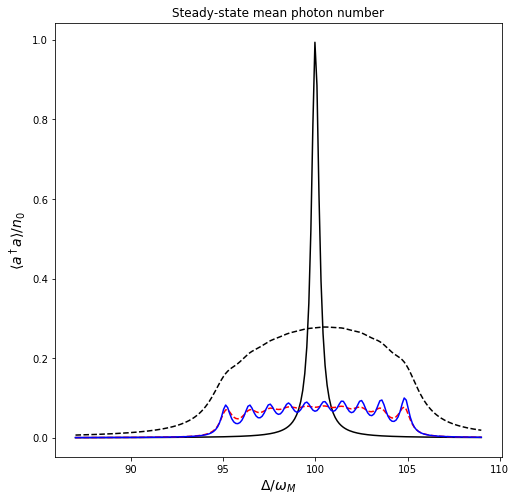

In [59]:
tlist = np.linspace(0, 100.0, 800)
fig, ax= plt.subplots(1,1,figsize=(8,8))
linestyle =['-','--','--','-']
color=['black', 'black', 'r', 'b']

for j in [0]:
    w_a  = w_a_j[j]  
    w_L  = w_L_j[j]
    Delta_aL = w_a - w_L
    
    g_am = g_am_j[j] 
    g_ac = g_ac_j[j]
    g_ef = g_cm + 2 * g_am * (g_ac/w_a)**2
    g_i = [0, g_ef, g_ef,g_ef]
    
    minn_c = w_L- 37  #- shift  #minn_c = w_L - 4
    maxx_c = w_L - 59 #+ shift  #maxx_c = w_L + 11
    w_cLlist = np.linspace((minn_c )* w_m, (maxx_c ) * w_m, 201)
    g_ef = g_cm + 2 * g_am * (g_ac/Delta_aL)**2
    
    pllot2  = np.zeros((len(w_cLlist),4))
    xplot = []
    
    for i in [ 0, 1, 2, 3]: #[0, 1, 2, 3]:
        g_eff_i = [0, g_ef,g_ef,g_ef]
        g_eff= g_eff_i[i]
        kappa = kappa_i[i]
        n_th            = n_th_i[i]
        F_L   = sqrt(kappa) * 0.01        # 
        n, c_ops, a, H0 = mean_steady1a(w_m, w_L, w_a, Delta_aL, w_cLlist, g_ac, g_cm, g_am,g_eff, n_th, kappa, gamma, F_L)    

        solvers = ['direct','power','eigen','iterative-gmres','iterative-bicgstab']  # methods 
        # only for ['iterative-gmres','iterative-bicgstab']---  use_rcm = True
        use_rcm = False
        rho0 = steadystate(H0, c_ops, method=solvers[2], tol=1e-14)
        n_0 = expect(a.dag()*a,rho0) 
    
        ax.plot(w_L - w_cLlist/w_m + shift, n/n_0, linestyle =linestyle[i], color=color[i])
        ax.set_xlabel(r'$\Delta/ \omega_M $', fontsize=14)
        ax.set_ylabel(r'$\langle a^ \dagger a  \rangle /n_0 $', fontsize=14)    # (r'$ e $',fontsize=16,color='red')
        ax.set_title('Steady-state mean photon number')
        
        xplot = w_L - w_cLlist/w_m + shift
        pllot1a[: , i] = n/n_0
#######

#######        
plt.savefig("SteaSt_MeanPhoton_1a.pdf") # , dpi=50
plt.show()

### Fig. 1a

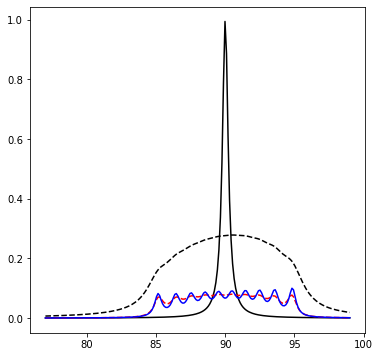

In [60]:

"""xarray = np.array([2, 4, 6, 8, 10, 12])
yarray = np.array([0, 1, 2, 3, 4, 5])
zarray = np.array([10, 8.5, 7.4, 6.7656, 0.004, -1.54])
data = np.column_stack([xarray, yarray , zarray])
np.savetxt("test.txt" , data, fmt=['%s','%s','%s'])
data = np.loadtxt('test.txt')
plt.plot(data[:,0], data[:,1], data[:,2])
plt.show()"""
xarray = xplot
black = pllot1a[: , 0]
bblack = pllot1a[: , 1]
red = pllot1a[: , 2]
blue = pllot1a[: , 3]
data1a = np.column_stack([xarray, black , bblack,red ,blue])
np.savetxt("Fig1a.txt" , data2a, fmt=['%s','%s','%s','%s','%s'])

linestyle =['-','--','--','-']
color=['black', 'black', 'r', 'b']
fig, ax= plt.subplots(1,1,figsize=(6,6))
for i in [1,2,3,4]:
    plt.plot(xarray-10, data1a[:,i], linestyle = linestyle[i-1], color = color[i-1])
plt.show()

In [13]:
w_m  = 1                       # mechanical frequency
#w_c  = 750. * w_m              # varaible 
w_a_j  = [900       , 900        , 1500 ]
w_L_j =  [700       , 840        , 1000 ]
g_am_j = [ 30       , 11.        , 50       ]
g_ac_j = [0.86 * 30 , 11. * 1.16 , 1.0 * 50 ]



#minn = [7]
#maxx = [12]
######
#minn_c = w_L_j[] + minn #
#maxx_c = w_L_j[] - maxx #
#w_cLlist = np.linspace((minn_c )* w_m, (maxx_c) * w_m, 101)
Delta_aL = w_a_j[2] - w_L_j[2]

g_cm = 0.001 * w_m 
##########

#shift = g_ac_j[0]**2/Delta_aL

g_eff  = g_cm + 2 * g_am_j[2] * (g_ac_j[2]/Delta_aL)**2
#shift 
g_eff

1.0010000000000001

In [20]:
#np.savetxt(datafile_path , data, fmt=['%d','%d'])
xarray = np.array([2, 4, 6, 8, 10, 12])
yarray = np.array([0, 1, 2, 3, 4, 5])
zarray = np.array([10, 8.5, 7.4, 6.7656, 0.004, -1.54])
data = np.column_stack([xarray, yarray , zarray])
np.savetxt("test.txt" , data, fmt=['%s','%s','%s'])

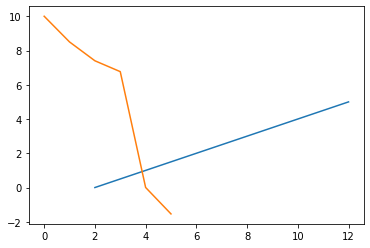

In [22]:
data = np.loadtxt('test.txt')

plt.plot(data[:,0], data[:,1], data[:,2])
plt.show()